In [1]:
import awkward as ak
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torch, h5py

from torch.utils.data import DataLoader
from glob import glob
#from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from models.particle_transformer import ParticleTransformer
from utils.data import Dataset, cycle
from train import load_model

In [7]:
for f in glob('/data/fudawei/GenMET/data/test/*/*.hdf5'):
    with h5py.File(f, 'r') as file:
        arr = file['event_truths'][:]
        print(f, np.max(arr), np.min(arr))
    

/data/fudawei/GenMET/data/test/DYJetsToMuMu_H2ErratumFix_TuneCP5_13TeV-powhegMiNNLO-pythia8-photos/NanoV9MCPostVFP_10.hdf5 797.56714 -584.9505
/data/fudawei/GenMET/data/test/DYJetsToMuMu_H2ErratumFix_TuneCP5_13TeV-powhegMiNNLO-pythia8-photos/NanoV9MCPostVFP_50.hdf5 484.51978 -372.34348
/data/fudawei/GenMET/data/test/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NanoV9MCPostVFP_10.hdf5 661.8976 -512.77704
/data/fudawei/GenMET/data/test/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NanoV9MCPostVFP_100.hdf5 936.4389 -772.3514
/data/fudawei/GenMET/data/test/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NanoV9MCPostVFP_50.hdf5 789.9437 -855.6592
/data/fudawei/GenMET/data/test/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NanoV9MCPostVFP_20.hdf5 745.2827 -693.31726


In [2]:
dataset = Dataset(glob('/data/fudawei/GenMET/data/train/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/*'), max_PF_num=1000)
dataloader = DataLoader(dataset=dataset, batch_size=128, shuffle=True, drop_last=False)


TypeError: a bytes-like object is required, not 'str'

In [20]:
lazy_files=[h5py.File(f, 'r') for f in glob('/data/fudawei/GenMET/data/train/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/*')]
lazy_files[0].attrs['n_events']

92000

In [7]:
import matplotlib.pyplot as plt

(array([34., 13.,  5.,  1.,  2.,  2.,  0.,  0.,  1.,  0.]),
 array([ 1000.,  1900.,  2800.,  3700.,  4600.,  5500.,  6400.,  7300.,
         8200.,  9100., 10000.]),
 <BarContainer object of 10 artists>)

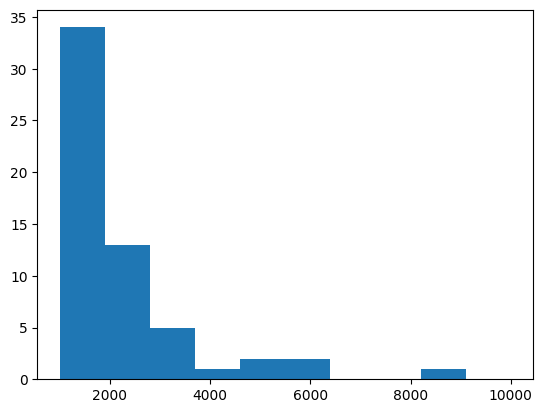

In [26]:
plt.hist(torch.abs(dataset.targets[torch.any(torch.abs(dataset.targets)>1e3, dim=-1)]).flatten(), range=(1e3, 1e4))

In [ ]:
dataset.features[torch.any(torch.abs(dataset.targets)>1e3, dim=-1)]

tensor([[[ 0.8989,  0.5293,  0.5747,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.9326,  2.3228,  1.7344,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.1038, -0.2361,  0.1974,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.5020,  1.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.4047,  0.5146,  0.5636,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.8027, -0.1238,  0.1127,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.7559,  0.5342,  0.5889,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.6746,  1.5474,  1.4187,  ...,  0.0000,  0.0000,  0.0000],
         [ 2.7012,  3.0991,  0.1033,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.9961,  1.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.6837, -0.5337,  0.5857,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.3222,  0.0227,  0.0607,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5884,  0.7056,  0.6782,  ...,  0.0000,  0.0000,  0.0000],
         [ 2.3345,  0.7896,  0.4728,  ...,  0

In [48]:
dataset.targets[torch.any(dataset.targets == torch.min(dataset.targets), dim=-1)]

tensor([[ 1789097.1250, -1634775.5000]])

In [24]:
with open('/data/fudawei/GenMET/output/MET/b=512_lr=0.001_EMAmu=0.999/model/checkpoint_2050.pt', 'rb') as f:
    loaded_obj = torch.load(f, map_location='cpu')

In [31]:
loaded_obj['model']['embed.input_bn.running_var']

tensor([2.4802e+01, 9.8404e-01, 1.5062e+00, 4.2042e-03, 1.5117e+00,        nan,
        1.3802e-01, 1.4600e+04, 3.2316e-01, 1.8926e+00, 2.2874e-01, 2.2944e-01,
        1.3003e+01, 1.3087e+01])

In [ ]:
for k, v in loaded_obj['model'].items():
    print(k)
    print(v)

In [3]:
dataloader = cycle(DataLoader(dataset=dataset, batch_size=1024, shuffle=True, drop_last=False))
inputs, targets = next(dataloader)

In [5]:
inputs.shape

torch.Size([1024, 14, 256])

In [ ]:
model = ParticleTransformer(
    input_dim=len(features),
    output_dim=len(targets),  
    # network configurations
    pair_input_dim=4,
    use_pre_activation_pair=False,
    embed_dims=[128, 512, 128],
    pair_embed_dims=[64, 64, 64],
    num_heads=8,
    num_layers=8,
    num_cls_layers=2,
    block_params=None,
    cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
    fc_params=[],
    activation='gelu',
    # misc
    trim=True,
    for_inference=False,
)

In [8]:
outputs = model(inputs)

/home/fudawei/GenMET/models/particle_transformer.py:546: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):


In [12]:
import torch